# Get depth data for pose detections

## Setup

In [235]:
import sys
sys.path.append("../")

In [236]:
import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import cv2
from common import plot_helpers
from skimage.segmentation import chan_vese
import pathlib
import json
import scipy
from sklearn.neighbors import NearestNeighbors
from mpl_toolkits import mplot3d
from tqdm import tqdm
from common.realsense_params import MIN_VALID_DEPTH_METERS
from common.realsense_params import MAX_VALID_DEPTH_METERS

np.set_printoptions(suppress=True)
%matplotlib inline 
# %matplotlib notebook

In [237]:
MIN_VALID_DEPTH_MM = MIN_VALID_DEPTH_METERS*1000
MAX_VALID_DEPTH_MM = MAX_VALID_DEPTH_METERS*1000


In [238]:
colormap = mcolors.LinearSegmentedColormap.from_list(
    "", plt.cm.viridis.colors, N=0xFFFF)

In [239]:
# subj='QKZF-SWAL-UJPN'
# cam='lower'
# algorithm='openpose:25B'
# activity='simon-says'
# color_idx=1300

cam='upper'
algorithm='mp-hands'
activity='target-touch'
hand='left'
color_idx=22

data = h5py.File(f'/home/mjsobrep/Downloads/data/{subj}/{activity}/full_data-vid.hdf5', 'r')
pose_data=h5py.File(f'/home/mjsobrep/Downloads/data/{subj}/{activity}/full_data-novid.hdf5', 'r')
depth_idx=data[f'vid/{cam}/color/matched_depth_index'][color_idx]
color_img=data[f'vid/{cam}/color/data'][color_idx]
depth_img=data[f'vid/{cam}/depth/data'][depth_idx]

if algorithm=='mp-hands':
    poses=pose_data[f'vid/{cam}/pose/{algorithm}/{hand}/keypoints-median5/color'][color_idx][:,:2]
else:
    poses=pose_data[f'vid/{cam}/pose/{algorithm}/keypoints-median5/color'][color_idx]

In [240]:
depth_img[depth_img < MIN_VALID_DEPTH_MM] = 0
depth_img[depth_img > MAX_VALID_DEPTH_MM] = 0

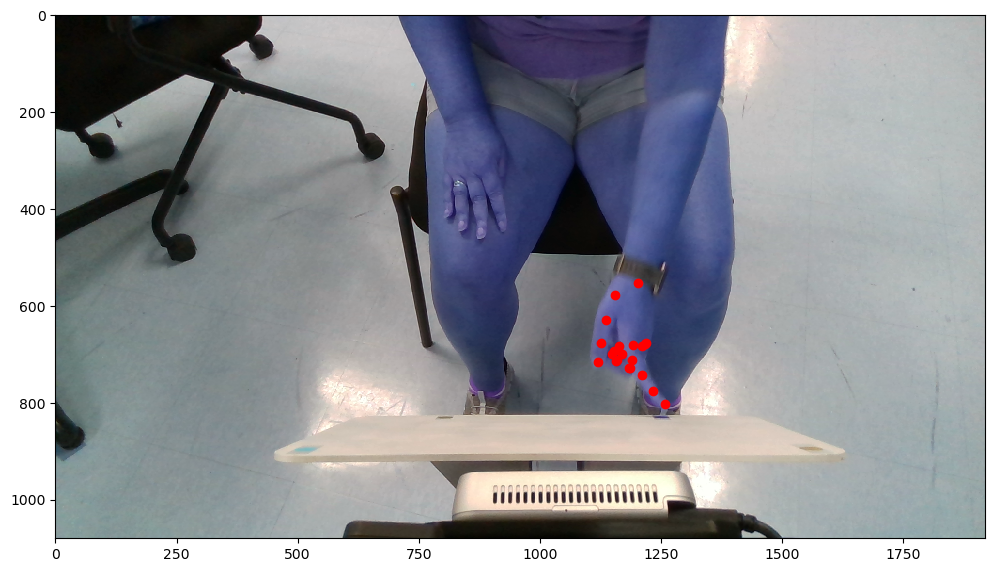

In [241]:
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(color_img)
plt.plot(poses[:,0], poses[:,1],'or')

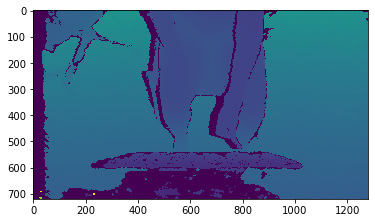

In [242]:
plt.imshow(depth_img)

## Intrinsics and Extrinsics

In [243]:
directory = pathlib.Path('/home/mjsobrep/Downloads/data/')
with open(directory/'transforms.json', encoding='utf-8') as json_file:
    transforms = json.load(json_file)

trans = (np.array([trans['translation']
                   for trans in transforms['robot'][cam].values()]))
rot = (np.array([trans['rotation']
                 for trans in transforms['robot'][cam].values()]))

# TODO: construct H matrix and use cv2 built in cv2.warpPerspective
r_cd = np.asarray(rot[0]).reshape(3, 3) 
t_cd = np.asarray(trans[0]).reshape(3, 1) * 1000 # convert from meters to millimeters 
k_c = data[f'vid/{cam}/color/data'].attrs['K'].reshape(3, 3)
inv_kc = np.linalg.inv(k_c)
k_d = data[f'vid/{cam}/depth/data'].attrs['K'].reshape(3, 3)

In [244]:
print(f'Kc:\n{k_c}')
print(f'Kd:\n{k_d}')
print(f'R:\n{r_cd}')
print(f'T:\n{t_cd}')

Kc:
[[1388.69726562    0.          980.37963867]
 [   0.         1387.66137695  547.88409424]
 [   0.            0.            1.        ]]
Kd:
[[897.11767578   0.         639.48754883]
 [  0.         897.11767578 360.43386841]
 [  0.           0.           1.        ]]
R:
[[ 0.99997014 -0.00298816 -0.00712956]
 [ 0.00296932  0.99999207 -0.00265167]
 [ 0.00713742  0.00263042  0.99997109]]
T:
[[14.8741696]
 [-0.2114892]
 [ 0.2002237]]


## Depth to color

Here we map the depth to the color images by passing through the indeces from the depth space to the color space.
The indeces are first made homogenous, then de-projected from the depth imager to world coordinates, using
the inverse of the depth K matrix. 

In [321]:
# Grid of index values | row 0: x, row 1: y 
indices=np.reshape(np.indices(np.flip(depth_img.shape)), (2,-1))
# Made homogenous by adding 1 to bottom | row 0: x, row 1: y, row 2: 1
indices_h = np.concatenate((indices, np.ones((1,indices.shape[1]))))
# Transform to world using inverse of depth imager K matrix and remove scale ambiguity by multiply by z
# z is stored in milimeters, but everything else is meters
world_d = (np.linalg.inv(k_d)@indices_h)*(np.reshape(depth_img,(1,-1),order='F'))

# Construct the homogenous tranformation between color and depth
HT = np.eye(4)
HT[:3, :3] = r_cd.T
HT[:3, 3] =  (t_cd).flatten() # TODO: is this complete
# # Make the inverse of that
HT_inv = HT.copy()
HT_inv[:3, :3] = np.linalg.inv(HT[:3, :3])
HT_inv[:3, 3] = -HT_inv[:3, :3]@HT[:3, 3]

# Make world coordinate homogenous
world_d_h = np.concatenate((world_d, np.ones((1, world_d.shape[1]))))
# Bring world coordinates from depth camera space to rgb camera space
world_c_h = HT@world_d_h
# Divide out depth to move back to pixel coordinates (should this come before/after the next step)
# world_c = world_c_h[:3,:]/world_c_h[2,:]
# Apply the camera projection matrix to finally end up back in rgb camera pixel coordinates
px_color = (k_c@world_c_h[:3,:])
valid_px_color = px_color[2,:] != 0
px_color_norm = px_color[:,valid_px_color]/px_color[2,valid_px_color]
depth_color = world_c_h[2,valid_px_color]
color_pixels = px_color_norm[:2,:].T

Check HT

In [322]:
print(f'HT:\n{HT}')

HT:
[[ 0.99997014  0.00296932  0.00713742 14.8741696 ]
 [-0.00298816  0.99999207  0.00263042 -0.2114892 ]
 [-0.00712956 -0.00265167  0.99997109  0.2002237 ]
 [ 0.          0.          0.          1.        ]]


These transformations are pretty small. I doubt the rotations are quite accurate. 

### Test transformation from depth pixels to depth world and back

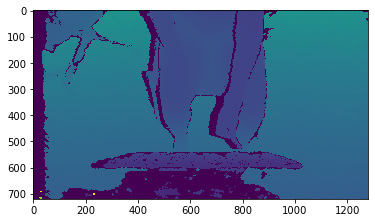

In [323]:
# project 3d points back into depth to make sure we did that right
im=np.zeros(depth_img.shape)
a=k_d@world_d
valid=a[2,:]!=0
a=a[:,valid]
dp=world_d[2,valid]
a=np.round(a/a[2,:]).astype('uint16')
im[a[1,:], a[0,:]]=world_d[2,valid]

plt.imshow(im)

### Test transformation to color camera pixel space

In [324]:
# %%timeit # 66.7 ms ± 733 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

im=np.zeros((color_img.shape[0], color_img.shape[1]))
x_low=np.atleast_2d(np.floor(color_pixels[:,0])).astype('uint16')
x_high=np.atleast_2d(np.ceil(color_pixels[:,0])).astype('uint16')
y_low=np.atleast_2d(np.floor(color_pixels[:,1])).astype('uint16')
y_high=np.atleast_2d(np.ceil(color_pixels[:,1])).astype('uint16')

for points in (np.concatenate((x_low.T,y_low.T),axis=1),
              np.concatenate((x_low.T,y_high.T),axis=1),
              np.concatenate((x_high.T,y_low.T),axis=1),
              np.concatenate((x_high.T,y_high.T),axis=1)):
    # points=np.ceil(c).astype('uint16')
    valid= np.all((points[:,0] > 0, points[:, 1]>0, points[:,0]<im.shape[1], points[:,1] <im.shape[0]), axis=0)
    im.shape
    im[points[valid,1], points[valid,0]] = world_c_h[2, valid]

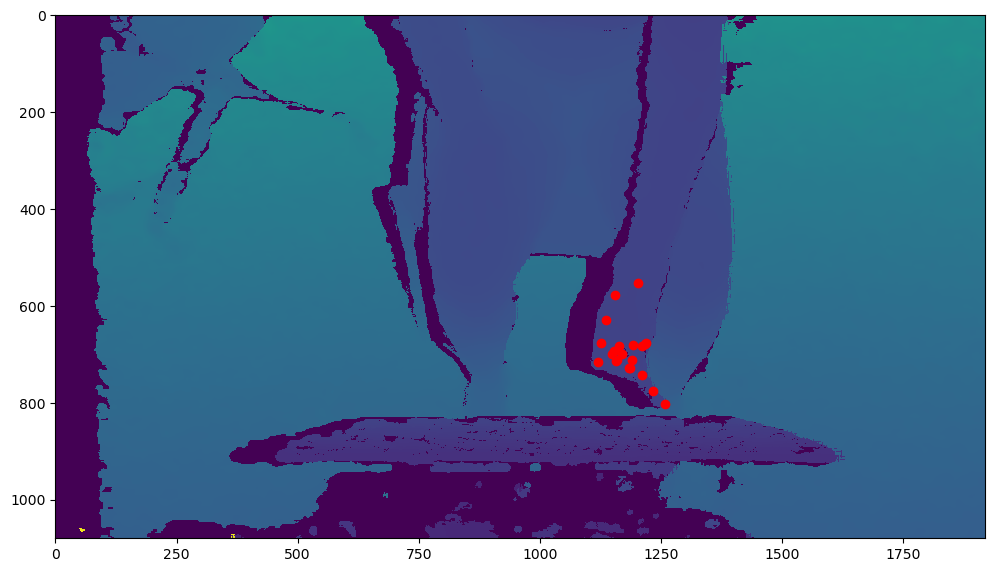

In [325]:
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(im)
plt.plot(poses[:,0], poses[:,1],'or')

Get poses in 3D

In [326]:
np.concatenate((poses, np.ones((poses.shape[0],1))),axis=1).T

array([[1203.27075195, 1155.04125977, 1136.66455078, 1125.83947754,
        1121.06787109, 1192.89941406, 1211.69104004, 1233.66479492,
        1257.60839844, 1210.55944824, 1183.7677002 , 1157.02038574,
        1149.25952148, 1218.00061035, 1186.43725586, 1159.12780762,
        1152.43127441, 1218.55859375, 1189.29406738, 1168.99804688,
        1164.2767334 ],
       [ 552.24047852,  578.2288208 ,  629.08447266,  677.11590576,
         714.57952881,  679.67175293,  741.69970703,  775.98291016,
         802.56341553,  681.55566406,  727.80853271,  713.55578613,
         698.92181396,  679.03289795,  727.83605957,  711.902771  ,
         693.04351807,  677.30102539,  711.89422607,  698.53790283,
         682.75830078],
       [   1.        ,    1.        ,    1.        ,    1.        ,
           1.        ,    1.        ,    1.        ,    1.        ,
           1.        ,    1.        ,    1.        ,    1.        ,
           1.        ,    1.        ,    1.        ,    1.        ,


In [327]:
int_poses=np.round(poses).astype('uint16')
depths=im[int_poses[:,1],int_poses[:,0]]
poses_3d_c = (inv_kc@np.concatenate((poses, np.ones((poses.shape[0],1))),axis=1).T)*depths
print(f'Keypoint positions in milimeters:\n{poses_3d_c.T}')

Keypoint positions in milimeters:
[[128.62892101   2.51591599 801.40759433]
 [101.06714475  17.5719443  803.5632939 ]
 [ 89.53373969  46.55344286 795.56790105]
 [ 83.74781868  74.46015121 799.53592488]
 [ 82.61630136  97.96157527 815.48420797]
 [121.7032807   75.52691738 795.26252468]
 [133.10166542 111.60901832 799.08693531]
 [145.53802004 131.16375282 797.94747338]
 [161.45987483 148.43765777 808.7865302 ]
 [133.12797137  77.36868508 803.17404973]
 [120.12477736 106.34605264 820.19047043]
 [106.50427328  99.96512829 837.30506992]
 [102.07495505  91.35888245 839.36114007]
 [137.76989569  76.09532484 805.15064003]
 [121.55230024 106.23195703 819.18518364]
 [107.77470863  98.967509   837.30336403]
 [103.99161308  87.80289274 839.35772016]
 [138.09271801  75.09008035 805.14661695]
 [121.43650332  95.40597525 807.21346605]
 [113.72315066  90.90107155 837.28322103]
 [109.0304598   80.02505069 823.34254179]]


Overlay depth and color to check alignment

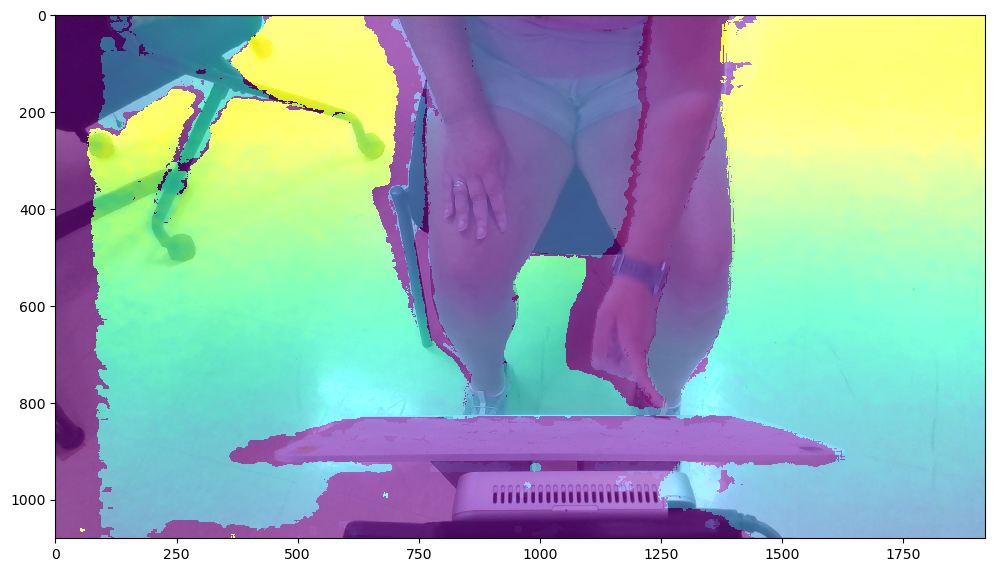

In [328]:
depth_img_s = plot_helpers.stretch_histogram(im.astype('uint16'))
depth_img_s = (colormap(depth_img_s) * 0xFFFF).astype(np.uint16)[:, :, :3]
# convert from 16 to 8 bit
depth_img_s = cv2.convertScaleAbs(depth_img_s, alpha=(0xFF/0xFFFF))
plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(cv2.addWeighted(cv2.cvtColor(color_img, cv2.COLOR_BGR2RGB), .5, depth_img_s, 1,0))

### Bring Back to depth coordinates

In [329]:
# %%timeit # 274 ms ± 6.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

# KD Tree to find the nearest depth point to each keypoint in the color image
nbrs = NearestNeighbors(n_neighbors=1, algorithm='kd_tree').fit(color_pixels)
_, id = nbrs.kneighbors(poses)
# Find the x and y positions in depth space for the corresponding keypoints
row = id%depth_img.shape[0]
col = (id-row)/depth_img.shape[0]

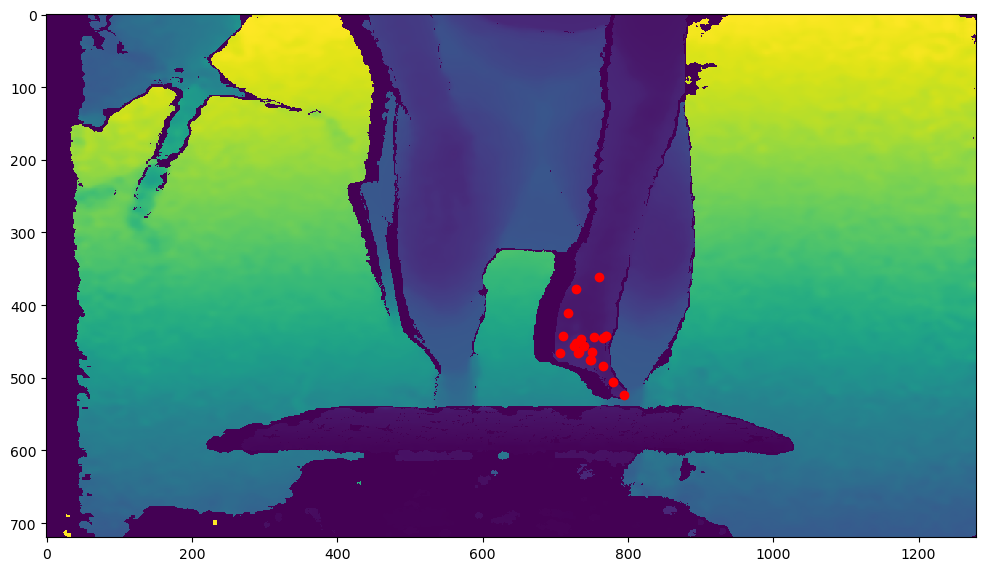

In [330]:
depth_img_s = plot_helpers.stretch_histogram(depth_img)
depth_img_s = (colormap(depth_img_s) * 0xFFFF).astype(np.uint16)[:, :, :3]
# convert from 16 to 8 bit
depth_img_s = cv2.convertScaleAbs(depth_img_s, alpha=(0xFF/0xFFFF))

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(depth_img_s)
plt.plot(col, row,'or')

In [331]:
poses_h=np.concatenate((row,col, np.ones((len(row),1))),axis=1).T
poses_d = depth_img[np.round(row).astype('uint16'),np.round(col).astype('uint16')]
poses_d = (np.linalg.inv(k_d)@poses_h)*(poses_d.T)
print(f'Keypoint positions in milimeters:\n{poses_d.T}')

Keypoint positions in milimeters:
[[-248.96066613  357.20178767  802.        ]
 [-234.34605619  330.31025672  804.        ]
 [-202.73381495  316.37615489  796.        ]
 [-176.10848981  311.72377139  800.        ]
 [-157.80074751  315.2295078   816.        ]
 [-173.45337526  348.31845273  796.        ]
 [-138.65520926  360.76973402  800.        ]
 [-118.88802817  372.78759317  799.        ]
 [-105.17562757  392.36610323  810.        ]
 [-174.30042176  362.57358269  804.        ]
 [-150.53128618  354.68233725  821.        ]
 [-162.05517943  346.14680622  838.        ]
 [-171.80526611  342.29127218  840.        ]
 [-176.53087062  367.96767133  806.        ]
 [-150.34793504  355.16436306  820.        ]
 [-162.98928208  347.08090887  838.        ]
 [-175.55059416  344.16393621  840.        ]
 [-177.42930348  367.96767133  806.        ]
 [-157.34884153  352.20351687  809.        ]
 [-171.19167587  353.19764697  837.        ]
 [-177.71775603  344.03791249  824.        ]]


In [332]:
# compare to from other side:
poses_d_from_c=(HT_inv@np.concatenate((poses_3d_c, np.ones((1,poses_3d_c.shape[1]))),axis=0))[:3,:]
print(f'Keypoint positions in milimeters in depth frame, calculated from color:\n{poses_d_from_c.T}')

Keypoint positions in milimeters in depth frame, calculated from color:
[[108.03094721   0.94062329 802.00326216]
 [ 80.40963607  15.90897655 804.00178286]
 [ 68.84697822  44.87720034 796.00053613]
 [ 62.94955036  72.75598554 800.00055476]
 [ 61.63413677  96.21157411 816.0021185 ]
 [100.93115734  73.94677664 796.00098855]
 [112.19411599 110.05229612 800.00155451]
 [124.57979005 129.64682466 799.0023262 ]
 [140.37227401 146.93912825 810.00014777]
 [112.29359728  75.80147454 803.998672  ]
 [ 99.08288364 104.69488013 820.99801324]
 [ 85.35983448  98.22818055 837.99811739]
 [ 80.94170662  89.60339883 839.99987607]
 [116.9250956   74.53666647 806.00498699]
 [100.51787202 104.58768987 820.00264428]
 [ 86.63322505  97.23434601 838.00285504]
 [ 82.86895757  86.05313752 840.00078253]
 [117.25094078  73.53239917 806.00062393]
 [100.51978131  93.793195   808.00196999]
 [ 92.60573661  89.18568867 838.00395108]
 [ 88.04507616  78.3327859  824.00157329]]


# SOMETHING IS WRONG WITH THIS